# <span id="toc">  Esercizio 10 - Parallelizzazione del GA </span>

- [Esercizio 10.1](#ex10_1)

- [Esercizio 10.2](#ex10_2)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## <span id="ex10_1">  Esercizio 10.1 </span>[^](#toc)

In questo esercizio ho esteso il codice sviluppato nell’Esercizio 9 introducendo la **parallelizzazione del GA** tramite la libreria **MPI (Message Passing Interface)**.  

Ogni processo MPI, detto "continente", esegue in modo indipendente un GA in cui porta avanti l'evoluzione della popolazione sullo stesso insieme di città, facendo una ricerca separata del percorso migliore.
In particolare il *rank 0* legge le coordinate, le distribuisce a tutti i processi, e ciascun processo inizializza la propria popolazione con un RNG decorrelato. Successivamente ad ogni generazione si esegue l'evoluzione con i parametri del GA.

Per favorire l’esplorazione dello spazio delle soluzioni ed evitare che i singoli continenti convergano troppo rapidamente a minimi locali, dopo un certo numero di generazioni $N_{\text{migr}}$ i continenti effettuano uno scambio dei migliori individui.

Il *rank 0* seleziona in modo casuale due processi distinti, identificati rispettivamente come "giver" e "receiver", e comunica questa scelta a tutti gli altri processi. Il giver invia quindi al receiver il proprio miglior individuo, che viene inserito al posto dell’individuo peggiore della popolazione locale. Dopo la sostituzione, il nuovo cromosoma viene validato, ne viene ricalcolata la fitness e la popolazione viene riordinata.  

Al termine dell’evoluzione, viene identificato il miglior percorso globale e il rank che lo ha trovato.

In questo modo ciascun continente beneficia periodicamente delle soluzioni trovate dagli altri, mantenendo diversità genetica e migliorando la probabilità di raggiungere un percorso ottimale, riducendo inoltre il tempo di calcolo.

## <span id="ex10_2">  Esercizio 10.2 </span>[^](#toc)

L’obiettivo dell'esercizio è applicare il GA parallelizzato al caso realistico di un campione di $110$ capoluoghi italiani, utilizzando $11$ processi MPI, ciascuno con la propria popolazione ed evoluzione indipendente.  

Per valutare l’efficacia della parallelizzazione ho eseguito un confronto tra due scenari differenti:  

- Senza migrazione, in cui i continenti evolvono in maniera del tutto indipendente.
- Con migrazione, in cui i continenti effettuano periodicamente lo scambio di individui migliori.

Per questa simulazione ho utilizzato una popolazione di $M=1000$ individui, facendo evolvere il sistema per $G=2000$ generazioni.
Rispetto all’esercizio precedente ho aumentato $G$, trattandosi di un problema molto più complesso e quindi con uno spazio delle soluzioni più ampio, consentendo all’algoritmo di esplorarlo in modo efficace.

Ho invece utilizzato gli stessi valori per i parametri del GA, ovvero:

```
2     p_sel
0.8   p_cross
0.06  p_m swap 
0.05  p_m inv
0.04  p_m shift
0.03  p_m mperm
```

In [2]:
#Numero di continenti
N_ranks = 11

### Parallelizzazione senza migrazioni

Di seguito riporto il grafico dell'evoluzione della lunghezza $L^{(1)}$ del miglior percorso in funzione del numero di generazioni, per ognuno degli $11$ continenti nel caso in cui non avvenga nessuna migrazione.

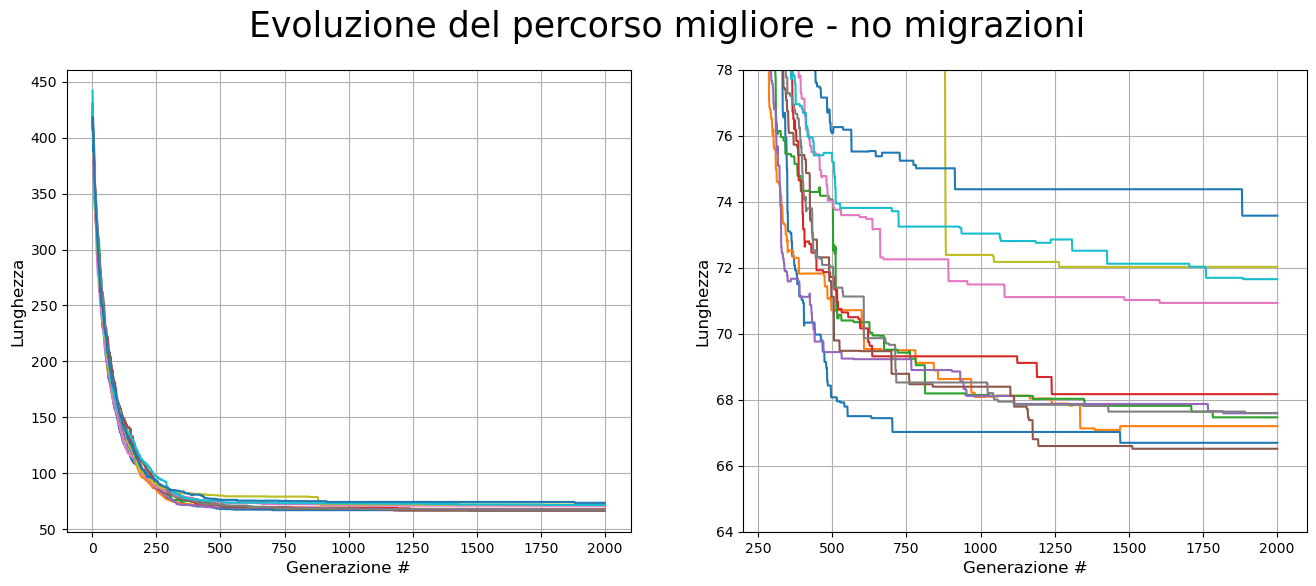

Valore minimo di L = 66.5142, trovato dal rank 5


In [3]:
# Lunghezza del percorso senza migrazioni
plt.figure(figsize=(16,6))
plt.suptitle('Evoluzione del percorso migliore - no migrazioni', fontsize=25)

data = []
best_vals = []

for r in range(N_ranks):
    filename = f'OUTPUT/no_migration/rank_{r}/best_length.dat'
    gen, best = np.loadtxt(filename, skiprows=1, unpack=True)
    data.append((gen, best))
    best_vals.append((best[-1], r))

plt.subplot(1,2,1)
for gen, best in data:
    plt.plot(gen, best)
plt.xlabel('Generazione #', fontsize=12)
plt.ylabel('Lunghezza', fontsize=12)
plt.grid(True)

plt.subplot(1,2,2)
for gen, best in data:
    plt.plot(gen, best)
plt.xlabel('Generazione #', fontsize=12)
plt.ylabel('Lunghezza', fontsize=12)
plt.xlim(200, 2100)
plt.ylim(64, 78)
plt.grid(True)

plt.show()

best_overall, best_rank = min(best_vals, key=lambda x: x[0])
print(f'Valore minimo di L = {best_overall:.4f}, trovato dal rank {best_rank}')

Dal grafico di sinistra si osserva che in tutti i processi l'algoritmo converge verso un valore minimo entro $\approx 500$ generazioni.

Nell'ingrandimento a destra si evidenzia nel dettaglio le differenze tra i singoli processi: ciascun continente converge verso una soluzione diversa e non tutti raggiungono lo stesso valore di lunghezza del percorso migliore.

Questo risultato mostra il limite dell’evoluzione indipendente, infatti in assenza di migrazioni ogni popolazione rischia di rimanere bloccata in minimi locali differenti, con conseguente variabilità nel valore finale.


### Parallelizzazione con migrazioni

Ho ripetuto la stessa procedura attivando la migrazione tra continenti durante l’evoluzione del GA.  

In una prima simulazione ho impostato $N_{migr} = 200$, ottenendo quindi un totale di $G/N_{migr} = 10$ migrazioni distribuite lungo tutta l’evoluzione.

Successivamente ho ridotto l’intervallo di migrazione a $N_{migr} = 20$, in modo da effettuare $G/N_{migr} = 100$ migrazioni totali.

Di seguito riporto i grafici dell'evoluzione della lunghezza $L^{(1)}$ del miglior percorso in funzione del numero di generazioni, per ciascuna delle due configurazioni appena descritte.

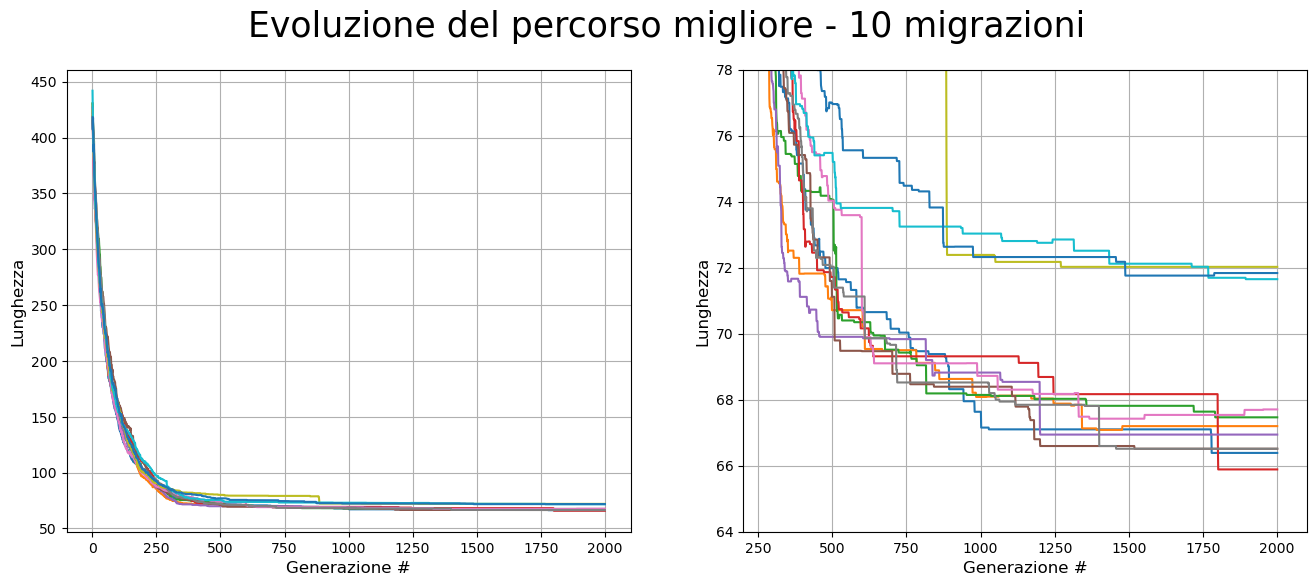

Valore minimo di L = 65.8877, trovato dal rank 3


In [4]:
# Lunghezza del percorso con 10 migrazioni
plt.figure(figsize=(16,6))
plt.suptitle('Evoluzione del percorso migliore - 10 migrazioni', fontsize=25)

data = []
best_vals = []

for r in range(N_ranks):
    filename = f'OUTPUT/10_migration/rank_{r}/best_length.dat'
    gen, best = np.loadtxt(filename, skiprows=1, unpack=True)
    data.append((gen, best))
    best_vals.append((best[-1], r))

plt.subplot(1,2,1)
for gen, best in data:
    plt.plot(gen, best)
plt.xlabel('Generazione #', fontsize=12)
plt.ylabel('Lunghezza', fontsize=12)
plt.grid(True)

plt.subplot(1,2,2)
for gen, best in data:
    plt.plot(gen, best)
plt.xlabel('Generazione #', fontsize=12)
plt.ylabel('Lunghezza', fontsize=12)
plt.xlim(200, 2100)
plt.ylim(64, 78)
plt.grid(True)

plt.show()

best_overall, best_rank = min(best_vals, key=lambda x: x[0])
print(f'Valore minimo di L = {best_overall:.4f}, trovato dal rank {best_rank}')

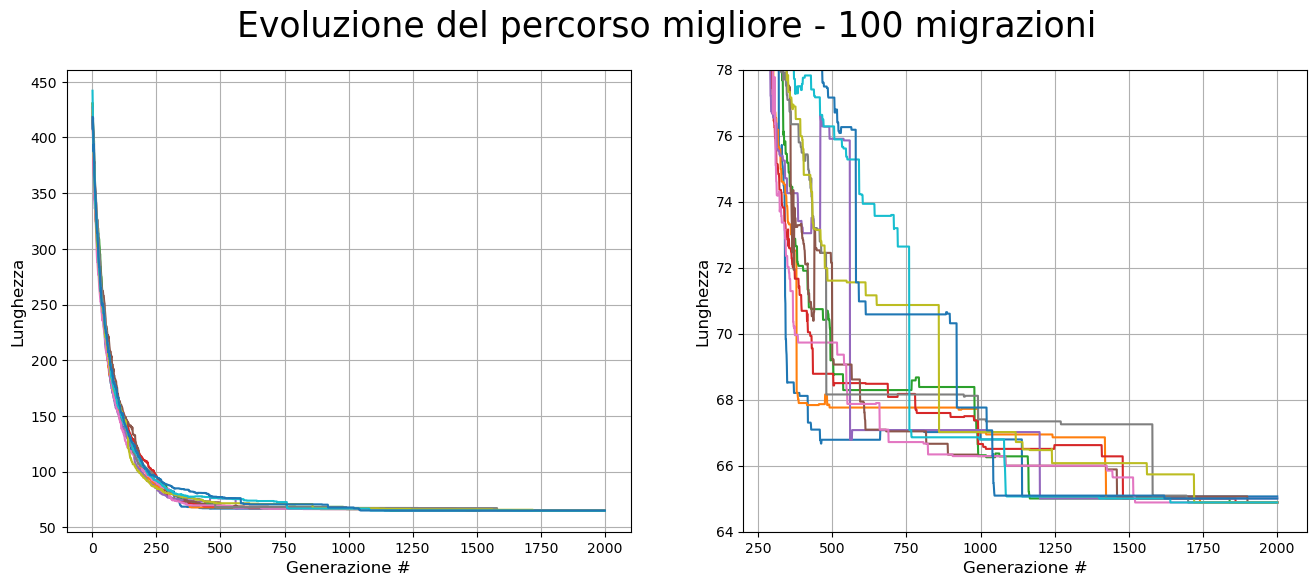

Valore minimo di L = 64.8868, trovato dal rank 1


In [5]:
# Lunghezza del percorso con 100 migrazioni
plt.figure(figsize=(16,6))
plt.suptitle('Evoluzione del percorso migliore - 100 migrazioni', fontsize=25)

data = []
best_vals = []

for r in range(N_ranks):
    filename = f'OUTPUT/100_migration/rank_{r}/best_length.dat'
    gen, best = np.loadtxt(filename, skiprows=1, unpack=True)
    data.append((gen, best))
    best_vals.append((best[-1], r))

plt.subplot(1,2,1)
for gen, best in data:
    plt.plot(gen, best)
plt.xlabel('Generazione #', fontsize=12)
plt.ylabel('Lunghezza', fontsize=12)
plt.grid(True)

plt.subplot(1,2,2)
for gen, best in data:
    plt.plot(gen, best)
plt.xlabel('Generazione #', fontsize=12)
plt.ylabel('Lunghezza', fontsize=12)
plt.xlim(200, 2100)
plt.ylim(64, 78)
plt.grid(True)

plt.show()

best_overall, best_rank = min(best_vals, key=lambda x: x[0])
print(f'Valore minimo di L = {best_overall:.4f}, trovato dal rank {best_rank}')

Analogamente al caso dell'evoluzione senza migrazioni, si osserva che anche introducendo scambi di individui tra continenti l'algoritmo converge sempre verso un valore minimo per tutti i processi.

Tuttavia è importante notare alcune differenze tra i tre scenari presi in esame, che mettono in evidenza l’effetto delle migrazioni sull’evoluzione del GA: rispetto al primo caso, la dispersione tra i processi risulta chiaramente ridotta, facendo sì che tutti si avvicinino allo stesso valore di lunghezza che risulta complessivamente migliore.

Inoltre si osserva che aumentando il numero di migrazioni, grazie al frequente scambio delle soluzioni migliori tutti i processi convergono praticamente alla stessa soluzione.

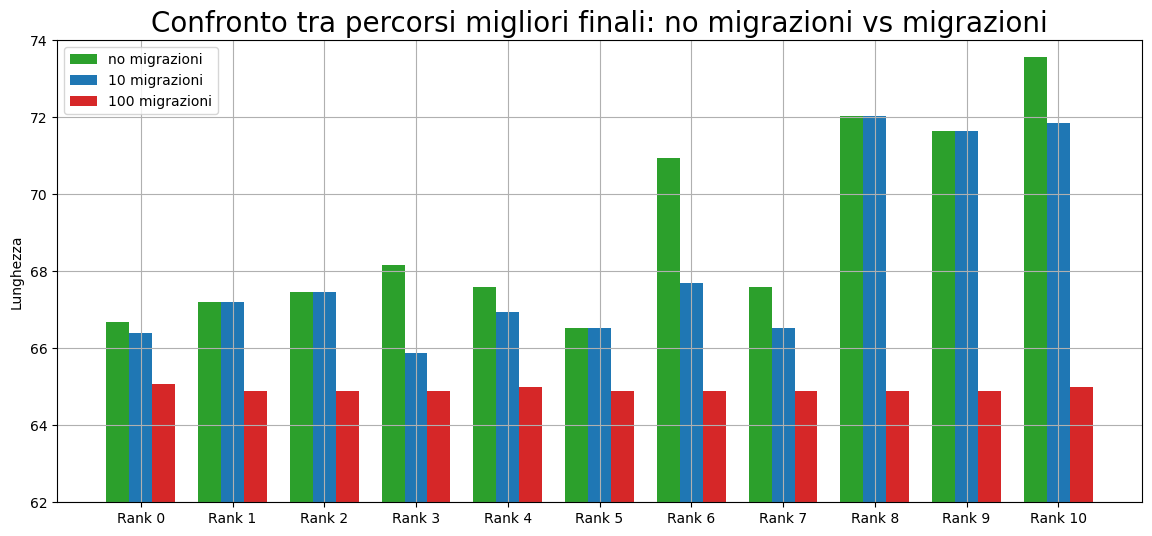

In [6]:
# Confronto dei percorsi
folders = ['no_migration', '10_migration', '100_migration']
labels = ['no migrazioni', '10 migrazioni', '100 migrazioni']
colors = ['tab:green', 'tab:blue', 'tab:red']

results = {f: [] for f in folders}

for f in folders:
    for r in range(N_ranks):
        filename = f'OUTPUT/{f}/rank_{r}/best_length.dat'
        best = np.loadtxt(filename, skiprows=1, usecols=(1), unpack=True)
        results[f].append(best[-1])
        
plt.figure(figsize=(14,6))

x = np.arange(N_ranks)
width = 0.25

for i, f in enumerate(folders):
    plt.bar(x + i*width, results[f], width=width, label=labels[i], color=colors[i])

plt.xticks(x + width, [f'Rank {r}' for r in range(N_ranks)], fontsize=10)
plt.ylabel('Lunghezza', fontsize=10)
plt.title('Confronto tra percorsi migliori finali: no migrazioni vs migrazioni', fontsize=20)
plt.ylim(62, 74)
plt.legend()
plt.grid(True)

plt.show()


Riporto un grafico riassuntivo di quanto detto fino ad ora, in cui vengono confrontati i percorsi migliori finali trovati da ciascun processo nei tre scenari considerati.

È importante sottolineare che, anche in assenza migrazioni, non è escluso che un singolo processo riesca a trovare una soluzione molto buona (in alcuni casi paragonabile o addirittura migliore rispetto a quelli con migrazioni), quindi non è sempre garantito che il miglior percorso globale provenga dalla parallelizzazione con più scambi.  

La differenza sostanziale sta però nella distribuzione dei risultati: senza migrazioni i valori finali sono molto dispersi tra i processi, mentre con un numero elevato di migrazioni tutti convergono praticamente allo stesso valore. Questo assicura che non sia solo un processo “fortunato” a trovare una buona soluzione, ma che tutti raggiungano percorsi simili, rendendo l'algoritmo più affidabile.

Di seguito ho riportato un grafico che rappresentare le città in coordinate cartesiane e traccia l'evoluzione del percorso migliore globale, trovato dal *rank 1* nel caso in cui ho utilizzato $100$ migrazioni, a partire dalla generazione iniziale fino a quella finale.

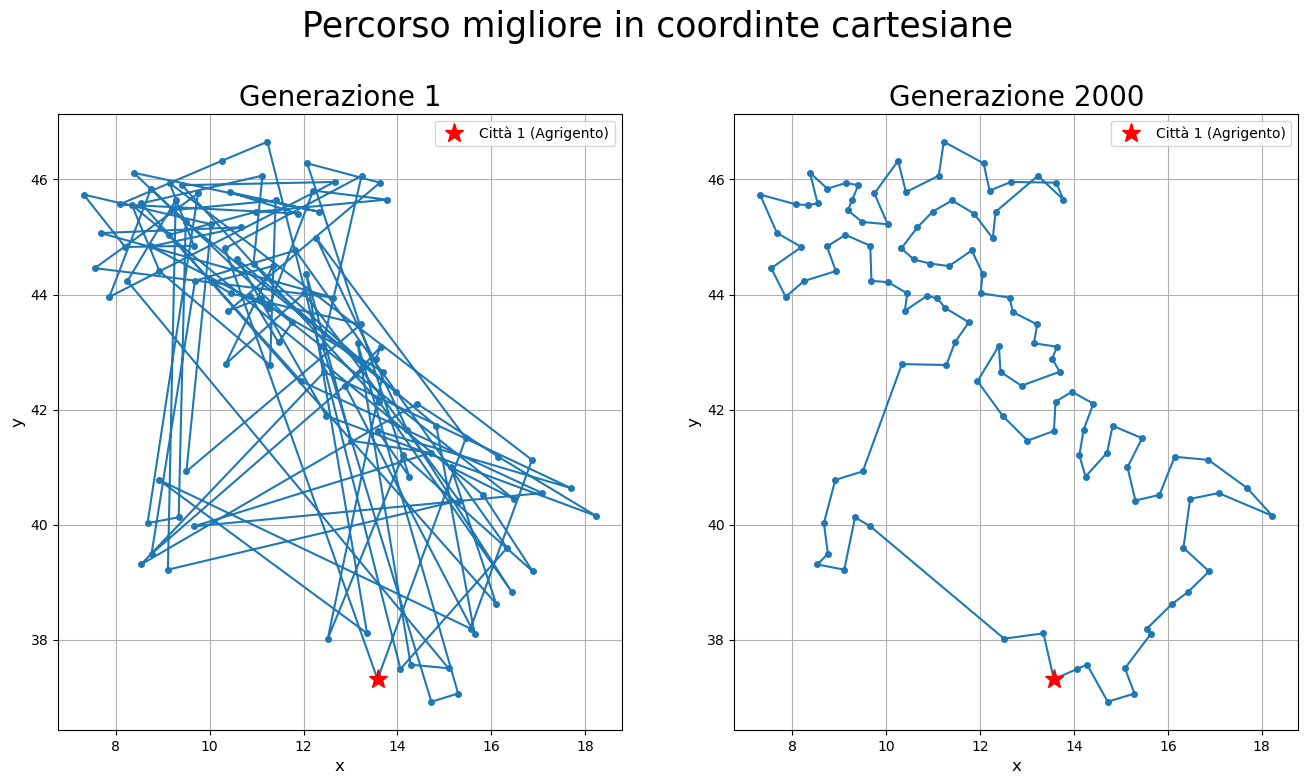

In [7]:
# Percorso migliore
plt.figure(figsize=(16,8))
plt.suptitle('Percorso migliore in coordinte cartesiane', fontsize=25, y=1.01)

x, y = np.loadtxt("OUTPUT/100_migration/rank_0/best_path.dat", usecols=(1,2), unpack=True)
N = 110

# Generazione 1
plt.subplot(1,2,1)
x_0 = x[0:N-1]
y_0 = y[0:N-1]
plt.plot(np.r_[x_0, x_0[0]], np.r_[y_0, y_0[0]], marker='o', markersize=4)
plt.plot(x[0], y[0], marker='*', color='r', markersize=14, linestyle='', label='Città 1 (Agrigento)')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Generazione 1', fontsize=20)
plt.grid(True)
plt.legend()

# Generazione 1000
plt.subplot(1,2,2)
x_f = x[-N:]
y_f = y[-N:]
plt.plot(np.r_[x_f, x_f[0]], np.r_[y_f, y_f[0]], marker='o', markersize=4)
plt.plot(x[0], y[0], marker='*', color='r', markersize=14, linestyle='', label='Città 1 (Agrigento)')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Generazione 2000', fontsize=20)
plt.grid(True)
plt.legend()


plt.show()